# RNN

原理就是在每一层创建一个新的节点用来保留当前这段文字的状态. 然后计算下一个单词的时候使用这个新的节点和x一起计算. 详情略

创建一个简单的Embedding


In [1]:
import torch
from torch import nn

word_2_idx = {"hello": 0, "world": 1}  # 创建一个索引

lookup_tensor = torch.tensor([word_2_idx["hello"]], dtype=torch.long)

# 使用pytorch初始化一个embedding, 2个单词5个维度的embedding. 注意, 这个初始化使用的就是随机生成的
embeds = nn.Embedding(2, 5)
hello_embed = embeds(lookup_tensor)  # 查看一个"hello"这个词的feature向量.
print(hello_embed)


tensor([[-0.2506, -1.5040,  0.2194,  0.6614, -1.3048]],
       grad_fn=<EmbeddingBackward0>)


直接使用Glove查看. 这里使用的glove需要下载一个新的包. 

```shell
pip install pytorch-nlp
```

如果直接使用的会下载一个2Gb组有的包, 这个包里面已经初始化好了一个100维feature的向量.

In [2]:
from torchnlp.word_to_vector import GloVe

vectors = GloVe()
vectors["hello"]


tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154,
        -0.3298, -0.1224, -0.4003, -0.0794, -0.1996, -0.0151, -0.0791, -0.1813,
         0.2068, -0.3620, -0.3074, -0.2442, -0.2311,  0.0980,  0.1463, -0.0627,
         0.4293, -0.0780, -0.1963,  0.6509, -0.2281, -0.3031, -0.1248, -0.1757,
        -0.1465,  0.1536, -0.2952,  0.1510, -0.5173, -0.0336, -0.2311, -0.7833,
         0.0180, -0.1572,  0.0229,  0.4964,  0.0292,  0.0567,  0.1462, -0.1919,
         0.1624,  0.2390,  0.3643,  0.4526,  0.2456,  0.2380,  0.3140,  0.3487,
        -0.0358,  0.5611, -0.2535,  0.0520, -0.1062, -0.3096,  1.0585, -0.4202,
         0.1822, -0.1126,  0.4058,  0.1178, -0.1971, -0.0753,  0.0807, -0.0278,
        -0.1562, -0.4468, -0.1516,  0.16

## Layer

$$[Batch, features] @ [Hiddens, features]^T + [Batch, Hiddens] @ [Hiddens , Hiddens]^T$$

比如我们创建一个神经网络进行训练, 一个batch进来的时候是3个单词, 然后我们对这个神经网络定义的每一个单词的向量数为100, 每一层进行计算使用的hidden临时weight的数量为20. 这里$[3,20]$是上一次计算得到的结果. 那么以此计算得到的公式就是

$$[30,100]@[20,100]^T+[3,20]@[20,20]^T=[3,20]$$

这里简单看一下rnn的一层的架构

In [3]:
# 建立一个100维的词向量, 然后使用10个hidden或者称为临时节点.
rnn = nn.RNN(100, 10)
print(rnn._parameters.keys())

print(
    rnn.weight_hh_l0.shape,  # hidden,hidden 的矩阵大小
    rnn.weight_ih_l0.shape,  # input, hidden 的矩阵大小 10,100 这里需要转置
    rnn.bias_hh_l0.shape,
    rnn.bias_ih_l0.shape,
)


odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0'])
torch.Size([10, 10]) torch.Size([10, 100]) torch.Size([10]) torch.Size([10])


初始化使用到的参数:

- input_size 输入维度, 单词的维度
- hidden_size memory或者叫hidden的属性
- num_layer 默认为1, 如果使用的话就可以使用多层神经网络.

forward(x,$h_0$) 给定当前的x, 注意这里是x不是x的转置. $h_0$表示的就是[layer,b,10] 

输出就是$h_t$,也就是最后一刻输出的结果[layer,b,10], 如果一层的话就是简单的[1,b,10], 也就是简单的$h$

整体的输出会输出全部的单词输出量, 也就是从$h_0$到$h_t$的最终权重输出, 比如我们有5个单词, 输出就是[5,b,10]

In [4]:
# 定义一个100维的循环神经网络, memory为20维度, 单层
rnn = nn.RNN(input_size=100, hidden_size=20, num_layers=1)
print(rnn)

# 我们这里模拟一个输入, 10个单词, 3个句子, 每个单词100维向量
# 需要注意的是, 我们定义的是一个时间序列输入, 因此最外层需要是词的数量, 想象一下三维空间, 最外层的轴需要是词, 这样才能一个一个词进行训练.
x = torch.rand(10, 3, 100)
out, h = rnn(x, torch.zeros(1, 3, 20))
print(out.shape, h.shape)  # h就是最后一个输出, out就是所有单词,每一次训练的输出


RNN(100, 20)
torch.Size([10, 3, 20]) torch.Size([1, 3, 20])


In [5]:
rnn = nn.RNN(100, 10, num_layers=2)
print(rnn._parameters.keys())

print(rnn.weight_hh_l0.shape, rnn.weight_ih_l0.shape)
print(rnn.weight_hh_l1.shape, rnn.weight_ih_l1.shape)  # 这里的内部状态不需要转换, 输入就是第一层的内部状态.


odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0', 'weight_ih_l1', 'weight_hh_l1', 'bias_ih_l1', 'bias_hh_l1'])
torch.Size([10, 10]) torch.Size([10, 100])
torch.Size([10, 10]) torch.Size([10, 10])


In [6]:
rnn = nn.RNN(100, 10, num_layers=4)
print(rnn)

x = torch.randn(10, 3, 100)
out, h = rnn(x)
print(out.shape, h.shape) # h0是4层


RNN(100, 10, num_layers=4)
torch.Size([10, 3, 10]) torch.Size([4, 3, 10])


RNNCell: 更加灵活的输入. 只会单纯的输入和输出进行. 具有和RNN类相同的输入和输出. 

- input_size 输入维度, 单词的维度
- hidden_size memory或者叫hidden的属性
- num_layer 默认为1, 如果使用的话就可以使用多层神经网络.

但是在forward参数就不同了, RNNCell使用的是`rnncell(xt,h)`. 

比如此处我们输入3个句子, 每一个句子的第一个单词, 这个单词有100维的向量, 因此输入的X就是$[3,100]$. 第二个参数就是memory, 比如我们有4层, 然后使用10个隐藏节点进行计算. 那么我们的h就是$[4,3,10]$. 最终的输出就是所有h的状态的集合, 注意我们并不知道有多少个h,所以大小可能是动态的. 

> 这种方法更像是神经网络的训练模式, 一个一个词进行feed in这样就得到了一个比较合适的输入方法. RNN默认情况下需要指定长度, 因此很可能出现截取或者填充等问题. 尽管这种方法比较底层, 但是却是比较常用的方法

In [7]:
print("x:", x.shape)
cell1 = nn.RNNCell(100, 20)  # 创建一个cell时间序列
h1 = torch.zeros(3, 20)  # 创建一个当前memory的容器

for xt in x:
    h1 = cell1(xt, h1)  # 进行一次计算求导, 我们得到了当前序列节点新的memory

print(h1.shape)


x: torch.Size([10, 3, 100])
torch.Size([3, 20])


In [13]:
print("x:", x.shape)

# 我们创建一个多序列节点的结构
cell1 = nn.RNNCell(100, 30)
cell2 = nn.RNNCell(30, 20)  # 这里的输入是第一层的输出
h1 = torch.zeros(3, 30)
h2 = torch.zeros(3, 20)
for xt in x:
    h1 = cell1(xt, h1)
    h2 = cell2(h1, h2)  # 第二个cell需要输入第一个cell的h

print(h2.shape)


x: torch.Size([10, 3, 100])
torch.Size([3, 20])


## 波形案例

我们可以使用numpy来定义正弦波形, 这里我们有50个点, 然后用50个点预测后面的状态. 因此, 我们的输入就是[50,b,1]. 

In [14]:
import numpy as np

num_time_steps = 50

# 初始相位,我们是随机进行采样. 我们随机的初始化位置, 也就是初始化图像
start = np.random.randint(3, size=1)[0]
# 进行training数据进行生成
time_steps = np.linspace(start, start + 10, num_time_steps)
print("time_steps:", time_steps)
# 根据这50个点, 生成50个sin的结果
data = np.sin(time_steps)
data = data.reshape(num_time_steps, 1)
# 在这里, 我们输入就是0-48个点, 然后输出需要得到1-49点成为结果, 也就是比原来多1个点
x = torch.tensor(data[:-1]).float().view(1, num_time_steps - 1, 1)
y = torch.tensor(data[1:]).float().view(1, num_time_steps - 1, 1)


time_steps: [ 1.          1.20408163  1.40816327  1.6122449   1.81632653  2.02040816
  2.2244898   2.42857143  2.63265306  2.83673469  3.04081633  3.24489796
  3.44897959  3.65306122  3.85714286  4.06122449  4.26530612  4.46938776
  4.67346939  4.87755102  5.08163265  5.28571429  5.48979592  5.69387755
  5.89795918  6.10204082  6.30612245  6.51020408  6.71428571  6.91836735
  7.12244898  7.32653061  7.53061224  7.73469388  7.93877551  8.14285714
  8.34693878  8.55102041  8.75510204  8.95918367  9.16326531  9.36734694
  9.57142857  9.7755102   9.97959184 10.18367347 10.3877551  10.59183673
 10.79591837 11.        ]


In [15]:
input_size = 1
hidden_size = 16
output_size = 1
lr = 0.01


class Net(nn.Module):
    def __init__(
        self,
    ):
        super(Net, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,  # 这里我们定义了batch为第一个维度 [b,seq,h], 这样更好使用
        )
        self.linear = nn.Linear(hidden_size, output_size)  # 最终添加一个全连接层, output size 就是1

    # 这里输出就是[batch, seq, h], h:[b,1,h]
    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [b, seq, h]
        out = out.view(-1, hidden_size)  # 我们这里直接进行flattern操作
        out = self.linear(out)  # 线性输出就是[seq,1], 也就输出了一个结果
        out = out.unsqueeze(dim=0)  # 这里我们对y进行比较, 所以添加了一个维度, y的维度是[b,seq,1], 因为我们需要用MSE
        return out, hidden_prev


In [16]:
# 这里我们需要用mse, 因为结果是线性结果
model = Net()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

# 这里我们新建h0, [b, layer, hiddensize]
hidden_prev = torch.zeros(1, 1, hidden_size)

# 循环6000次
for iter in range(6000):
    # 随机生成xy
    start = np.random.randint(3, size=1)[0]
    time_steps = np.linspace(start, start + 10, num_time_steps)
    data = np.sin(time_steps)
    data = data.reshape(num_time_steps, 1)
    x = torch.tensor(data[:-1]).float().view(1, num_time_steps - 1, 1)
    y = torch.tensor(data[1:]).float().view(1, num_time_steps - 1, 1)

    output, hidden_prev = model(x, hidden_prev)
    hidden_prev = hidden_prev.detach()

    # 计算mse
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print("Iteration: {} loss {}".format(iter, loss.item()))


Iteration: 0 loss 0.4079281687736511
Iteration: 1000 loss 0.0012061619199812412
Iteration: 2000 loss 0.0009604257065802813
Iteration: 3000 loss 0.0005868563894182444
Iteration: 4000 loss 9.899263386614621e-05
Iteration: 5000 loss 0.0001778372679837048


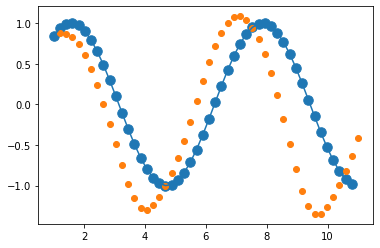

In [17]:
from matplotlib import pyplot as plt

# 进行预测

# 这里进行预测
predictions = []
# 取第一个sequence
input = x[:, 0, :]
for _ in range(x.shape[1]):
    # 然后将其拉伸成[b,seq,1]
    input = input.view(1, 1, 1)
    (pred, hidden_prev) = model(input, hidden_prev)
    input = pred
    predictions.append(pred.detach().numpy().ravel()[0])

x = x.data.numpy().ravel()
y = y.data.numpy()
plt.scatter(time_steps[:-1], x.ravel(), s=90)
plt.plot(time_steps[:-1], x.ravel())

plt.scatter(time_steps[1:], predictions)
plt.show()


在这里我们可以看到, 我们的input大小其实是1, 但是我们训练的时候要求input是49.

其实pytorch是可以自行调整input的大小的. 只要满足broadcast的结构, 就可以进行修正